# Cross-Case Composite Sensitivity Processing and Plotting

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Figs. 18, 20, S1-4; stats in Table 3

In [1]:
# Import statements
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime
import math
from scipy import stats
from metpy.interpolate import interpolate_to_points

# Import custom modules
from wofunits import wofunits
import centered_response as cr

# Define time string list of WoFS inits
cases = ['201905172200', '201905202030', '201905262000', '201905282230']

#state_time = datetime.datetime(2019,5,18,0)

# Define paths
sm_path = wofunits.paths['sm_path'] # path to storm motion csv files
resp_path = wofunits.paths['resp_path'] # path to response function files
outpath = wofunits.paths['outplot_path'] # path to save figures

### Files needed: 

### 4. Relevant WoFS files
### 7. Relevant MRMS files
### 8. Relevant sensitivity files
### 10. Relevant 3D WoFS files

## Define relevant functions

In [2]:
# For aligning storm motion vectors across cases for cross-case composite 
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.

    origin: coordinates about which to rotate coordinates (tuple of 2 numbers)
    point: coordinates to rotate (tuple of 2 numbers or arrays/lists of numbers)
    angle: angle to rotate by (number)
    
    """
    ox, oy = origin
    px, py = point
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)

    return qx, qy

# Caclulate 2D p-value fields
def calc_pstat(X, Y):
    """
    X: (case, n, y, x)   predictor residuals
    Y: (case, n)         response residuals

    Returns:
        pvals: (y, x)
    """

    n_case, n, ny, nx = X.shape

    # Flatten case and n into a single sample dimension
    Xf = X.reshape(n_case * n, ny, nx)       # (samples, y, x)
    Yf = Y.reshape(n_case * n)               # (samples,)

    # Expand for broadcasting
    Yf_ = Yf[:, None, None]                  # (samples, y, x)

    # Valid mask
    valid = np.isfinite(Xf) & np.isfinite(Yf_)

    # Number of valid samples at each gridpoint
    m = np.sum(valid, axis=0)                # (y, x)

    # OLS components
    sumXY = np.sum(np.where(valid, Xf * Yf_, 0.0), axis=0)   # (y, x)
    sumXX = np.sum(np.where(valid, Xf * Xf, 0.0), axis=0)    # (y, x)

    # Slope
    beta = sumXY / sumXX

    # Residuals and RSS
    resid = np.where(valid, Yf_ - beta[None, :, :] * Xf, np.nan)
    RSS = np.nansum(np.where(np.isfinite(resid), resid**2, 0.0), axis=0)

    # Degrees of freedom
    df = m - 2

    # Residual variance
    sigma2 = RSS / df

    # Standard error
    SE = np.sqrt(sigma2 / sumXX)

    # t-statistic
    tstat = beta / SE

    # p-values
    pvals = 2 * stats.t.sf(np.abs(tstat), df)

    # Invalid locations
    bad = (sumXX == 0) | (df <= 0)
    pvals[bad] = np.nan

    return pvals

# Calculate 2D semipartial sensitivity fields
def semipartial_sensitivity_field(X, Y, Z):
    """
    Compute:
      - partial sensitivity field (beta)
      - partial correlation field
      - p-value field

    For predictor X (M,Ny,Nx), predictand Y (M,), and control variable Z (M,).
    """

    M, Ny, Nx = X.shape

    # ---- Center variables ----
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean()
    Zc = Z - Z.mean()

    # ---- Variances ----
    VarX = np.sum(Xc**2, axis=0) / (M - 1)
    VarZ = np.sum(Zc**2) / (M - 1)

    # ---- Y corrected for Z ----
    CovYZ = np.sum(Yc * Zc) / (M - 1)
    m_ZtoY = CovYZ / VarZ
    Yres = Yc - (m_ZtoY * Zc)

    # ---- Covariance ----
    CovXYres = np.sum(Xc * Yres[:, None, None], axis=0) / (M - 1)
    
    # ---- Semipartial sensitivity (regression coefficient) ----
    sens = CovXYres / VarX

    # ---- Semipartial correlation ----
    VarYres = np.sum(Yres**2) / (M - 1)
    r_semi = CovXYres / np.sqrt(VarX * VarYres)

    # ---- t-statistic for partial correlation ----
    df = M - 2
    t_field = r_semi * np.sqrt(df / (1 - r_semi**2))

    # ---- two-sided p-values ----
    p_field = 2 * (1 - stats.t.cdf(np.abs(t_field), df=df))

    return sens, VarX, p_field, Xc, Yres

# Calculate 2D partial sensitivity fields
def partial_sensitivity_field(X, Y, Z):
    """
    Compute:
      - partial sensitivity field (beta)
      - partial correlation field
      - p-value field

    For predictor X (M,Ny,Nx), predictand Y (M,), and control variable Z (M,).
    """

    M, Ny, Nx = X.shape

    # ---- Center variables ----
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean()
    Zc = Z - Z.mean()

    # ---- Variances ----
    VarX = np.sum(Xc**2, axis=0) / (M - 1)
    VarZ = np.sum(Zc**2) / (M - 1)

    # ---- Covariances ----
    CovXY = np.sum(Xc * Yc[:, None, None], axis=0) / (M - 1)
    CovXZ = np.sum(Xc * Zc[:, None, None], axis=0) / (M - 1)
    CovYZ = np.sum(Yc * Zc) / (M - 1)

    # ---- Residuals corrected for Z ----
    m_ZtoX = CovXZ / VarZ
    X_part = Xc - (m_ZtoX[None, :, :] * Zc[:, None, None])
    
    m_ZtoY = CovYZ / VarZ
    Y_part = Yc - (m_ZtoY * Zc)
    
    # ---- Partial covariance and variance ----
    CovXY_gZ = CovXY - CovXZ * CovYZ / VarZ
    VarX_gZ = VarX - (CovXZ**2) / VarZ
    
    # ---- Partial sensitivity (regression coefficient) ----
    sens = CovXY_gZ / VarX_gZ

    # ---- Partial correlation ----
    VarY = np.sum(Yc**2) / (M - 1)
    VarY_gZ = VarY - (CovYZ**2) / VarZ
    r_partial = CovXY_gZ / np.sqrt(VarX_gZ * VarY_gZ)

    # ---- t-statistic for partial correlation ----
    df = M - 3
    t_field = r_partial * np.sqrt(df / (1 - r_partial**2))

    # ---- two-sided p-values ----
    p_field = 2 * (1 - stats.t.cdf(np.abs(t_field), df=df))

    return sens, VarX_gZ, p_field, X_part, Y_part

## Define response functions and concatenate into single, composite 1D array

In [3]:
# Grab response functions (shape: case, mem)

respfuncs = []
for case in cases:
    wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)
    file_resp = f'{resp_path}/resp_UH25_30MIN_max_{resptime}.nc'
    ds = xr.open_dataset(file_resp)

    respfuncs.append(ds.UH25_30MIN.values - np.nanmean(ds.UH25_30MIN.values))
    
respfuncs = np.array(respfuncs)

# Residuals of instantaneous 30-min lead time UH across all cases, concatenated into 1D array
uh_30_lt = np.genfromtxt('uh_30min_inst.csv', delimiter=',')

## Rotate each case to storm motion and interpolate to regular grid (only select variables)

In [4]:
t2s,td2s,u10s,v10s,bwd01s,bwd06s,srh01s,srh03s,mlcapes,mlcins,crefs=[],[],[],[],[],[],[],[],[],[],[]
for case in cases:

    print(f'Processing {case}')
    
    ############### Grab case metadata ####################
    
    wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)
    state_time = state_times[-3]
    
    ############### Process coordinates ####################
    
    xmesh,ymesh = cr.xy_mesh(case, state_time)
    
    # open storm motion csv files
    sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
    sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')
    
        # average storm motion components at chosen time
    sm_mean_x = np.nanmean(sm_x.iloc[:-1][f'{state_time.year}-{str(state_time.month).zfill(2)}-{str(state_time.day).zfill(2)} {str(state_time.hour).zfill(2)}:{str(state_time.minute).zfill(2)}:00'].values)
    sm_mean_y = np.nanmean(sm_y.iloc[:-1][f'{state_time.year}-{str(state_time.month).zfill(2)}-{str(state_time.day).zfill(2)} {str(state_time.hour).zfill(2)}:{str(state_time.minute).zfill(2)}:00'].values)
    
        # calculate angle of storm motion relative to positive x-axis
    storm_ang = cr.calc_storm_ang(sm_mean_x, sm_mean_y)

    if case in ['201905172200','201905282230']:
        storm_ang = storm_ang-360
    elif case == '201905202030':
        storm_ang = storm_ang-180
    
    xrot, yrot = rotate(origin=(0,0), point=(xmesh,ymesh), angle=storm_ang)
    
    ############### Process netCDF file ####################
    
    ds1 = xr.open_dataset(f'''{wofs_casedir}/wofs_center_i{case}_v{str(state_time)[:-3].replace('-','').replace(' ','').replace(':','')}.nc''')
    #
    ds1 = ds1.assign_coords(X_DIST=(('south_north', 'west_east'), xmesh))
    ds1 = ds1.assign_coords(Y_DIST=(('south_north', 'west_east'), ymesh))
    
    ds1 = ds1.assign_coords(X_ROT=(('south_north', 'west_east'), xrot))
    ds1 = ds1.assign_coords(Y_ROT=(('south_north', 'west_east'), yrot))
    
    x = ds1["X_DIST"].isel(south_north=0)      # shape (west_east,)
    y = ds1["Y_DIST"].isel(west_east=0)        # shape (south_north,)
    
    ix = np.where((x >= -90) & (x <= 150))[0]
    iy = np.where((y >= -120) & (y <= 120))[0]
    
    xmin, xmax = ix.min(), ix.max()
    ymin, ymax = iy.min(), iy.max()
    
    ds1 = ds1.isel( south_north=slice(ymin, ymax + 1),
                    west_east=slice(xmin, xmax + 1) )

    
    t2_date,td2_date,u10_date,v10_date,bwd01_date,bwd06_date=[],[],[],[],[],[]
    srh01_date,srh03_date,mlcape_date,mlcin_date,cref_date=[],[],[],[],[]
    
    orig_pts = np.column_stack([np.concatenate(ds1.X_ROT),np.concatenate(ds1.Y_ROT)])
    new_pts = np.column_stack([np.concatenate(ds1.X_DIST),np.concatenate(ds1.Y_DIST)])

    print(f'Interpolating for {case}')
    for i in range(ds1.Member.size):
        t2 = ds1.T2.values[i,0]
        td2 = ds1.TD2.values[i,0]
        u10 = ds1.U10.values[i,0]
        v10 = ds1.V10.values[i,0]
        bwd01 = ds1.SHEAR_TOT1.values[i,0]
        bwd06 = ds1.SHEAR_TOT6.values[i,0]
        srh01 = ds1.SRH1_TRUE.values[i,0]
        srh03 = ds1.SRH3_TRUE.values[i,0]
        mlcape = ds1.MLCAPE.values[i,0]
        mlcin = ds1.MLCIN.values[i,0]
        cref = ds1.REFD_MAX.values[i,0]
    
        t2_interp = interpolate_to_points(orig_pts, np.concatenate(t2), new_pts, interp_type = 'linear')
        td2_interp = interpolate_to_points(orig_pts, np.concatenate(td2), new_pts, interp_type = 'linear')
        u10_interp = interpolate_to_points(orig_pts, np.concatenate(u10), new_pts, interp_type = 'linear')
        v10_interp = interpolate_to_points(orig_pts, np.concatenate(v10), new_pts, interp_type = 'linear')
        bwd01_interp = interpolate_to_points(orig_pts, np.concatenate(bwd01), new_pts, interp_type = 'linear')
        bwd06_interp = interpolate_to_points(orig_pts, np.concatenate(bwd06), new_pts, interp_type = 'linear')
        srh01_interp = interpolate_to_points(orig_pts, np.concatenate(srh01), new_pts, interp_type = 'linear')
        srh03_interp = interpolate_to_points(orig_pts, np.concatenate(srh03), new_pts, interp_type = 'linear')
        mlcape_interp = interpolate_to_points(orig_pts, np.concatenate(mlcape), new_pts, interp_type = 'linear')
        mlcin_interp = interpolate_to_points(orig_pts, np.concatenate(mlcin), new_pts, interp_type = 'linear')
        cref_interp = interpolate_to_points(orig_pts, np.concatenate(cref), new_pts, interp_type = 'linear')
    
        t2_date.append(t2_interp)
        td2_date.append(td2_interp)
        u10_date.append(u10_interp)
        v10_date.append(v10_interp)
        bwd01_date.append(bwd01_interp)
        bwd06_date.append(bwd06_interp)
        srh01_date.append(srh01_interp)
        srh03_date.append(srh03_interp)
        mlcape_date.append(mlcape_interp)
        mlcin_date.append(mlcin_interp)
        cref_date.append(cref_interp)

    t2s.append(t2_date)
    td2s.append(td2_date)
    u10s.append(u10_date)
    v10s.append(v10_date)
    bwd01s.append(bwd01_date)
    bwd06s.append(bwd06_date)
    srh01s.append(srh01_date)
    srh03s.append(srh03_date)
    mlcapes.append(mlcape_date)
    mlcins.append(mlcin_date)
    crefs.append(cref_date)

print('Finished interpolation')

Processing 201905172200
Interpolating for 201905172200
Processing 201905202030
Interpolating for 201905202030
Processing 201905262000
Interpolating for 201905262000
Processing 201905282230
Interpolating for 201905282230
Finished interpolation


### Reshape composite arrays to shape: (case, member, y, x)

In [5]:
# Reshape into arrays with dims: 4 cases x 36 members x Y x X
t2_interps = np.concatenate(t2s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
td2_interps = np.array(td2s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
u10_interps = np.array(u10s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
v10_interps = np.array(v10s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
bwd01_interps = np.array(bwd01s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
bwd06_interps = np.array(bwd06s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
srh01_interps = np.array(srh01s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
srh03_interps = np.array(srh03s).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
mlcape_interps = np.array(mlcapes).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
mlcin_interps = np.array(mlcins).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)
cref_interps = np.array(crefs).reshape(len(cases), ds1.Member.size,ds1.south_north.size,ds1.west_east.size)

# Subtract ensemble means to retain residuals
t2_interps = (t2_interps - np.mean(t2_interps, axis=1)[:,None,:,:])
td2_interps = (td2_interps - np.mean(td2_interps, axis=1)[:,None,:,:])
u10_interps = (u10_interps - np.mean(u10_interps, axis=1)[:,None,:,:])
v10_interps = (v10_interps - np.mean(v10_interps, axis=1)[:,None,:,:])
bwd01_interps = (bwd01_interps - np.mean(bwd01_interps, axis=1)[:,None,:,:])
bwd06_interps = (bwd06_interps - np.mean(bwd06_interps, axis=1)[:,None,:,:])
srh01_interps = (srh01_interps - np.mean(srh01_interps, axis=1)[:,None,:,:])
srh03_stats = np.nanmean(srh03_interps, axis=(2,3))
srh03_interps = (srh03_interps - np.mean(srh03_interps, axis=1)[:,None,:,:])
mlcape_interps = (mlcape_interps - np.mean(mlcape_interps, axis=1)[:,None,:,:])
mlcin_interps = (mlcin_interps - np.mean(mlcin_interps, axis=1)[:,None,:,:])

print('Finished processing')

Finished processing


In [6]:
state_var = srh03_interps

cov_xy = np.sum(state_var * respfuncs[:,:,None,None], axis=(0,1)) / (state_var.shape[0]*state_var.shape[1] - 1)  # (240,240)
var_x  = np.sum(state_var**2, axis=(0,1)) / (state_var.shape[0]*state_var.shape[1] - 1)
std_x = var_x**0.5
sens = cov_xy / var_x
stdsens = sens * std_x
pstat = calc_pstat(state_var, respfuncs)
pstat = np.where(np.isnan(np.mean(state_var, axis=(0,1))), np.nan, pstat)

/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:49: RuntimeWarning: invalid value encountered in divide
  beta = sumXY / sumXX
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:62: RuntimeWarning: invalid value encountered in divide
  SE = np.sqrt(sigma2 / sumXX)


### Compute and plot composite sensitivity fields

/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:49: RuntimeWarning: invalid value encountered in divide
  beta = sumXY / sumXX
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:62: RuntimeWarning: invalid value encountered in divide
  SE = np.sqrt(sigma2 / sumXX)
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:49: RuntimeWarning: invalid value encountered in divide
  beta = sumXY / sumXX
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:62: RuntimeWarning: invalid value encountered in divide
  SE = np.sqrt(sigma2 / sumXX)
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:49: RuntimeWarning: invalid value encountered in divide
  beta = sumXY / sumXX
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:62: RuntimeWarning: invalid value encountered in divide
  SE = np.sqrt(sigma2 / sumXX)
/var/folders/rj/ztrh47rj72x4pmrvtb

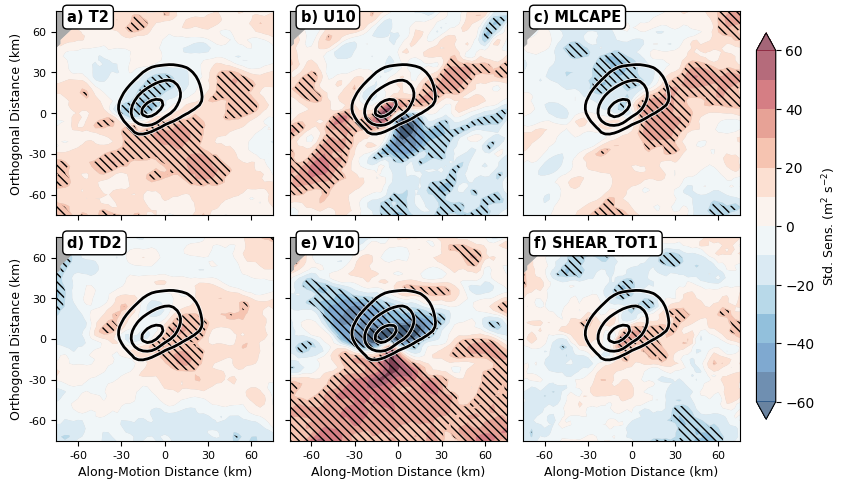

In [7]:
# Set case/plotting specs
save = False
statevars = [t2_interps,u10_interps,mlcape_interps,td2_interps,v10_interps, mlcin_interps]
statestrs = ['T2', 'U10', 'MLCAPE', 'TD2', 'V10', 'SHEAR_TOT1']
respvar = 'UH_25'
cref = np.mean(cref_interps, axis=(0,1))

################################# Define universal plotting specs ##########################################

xlimleft, xlimright = -40,60
ylimleft, ylimright = -60,50

levels = np.arange(-60,61,10)
ticks = levels[0::4]

axlabels = ['a)','b)','c)','d)','e)','f)','g)','h)']

################################# Define figure and plot ##########################################

fig, axs = plt.subplots(2, 3,figsize=(9,5))
axs = axs.flatten()

for i, ax in enumerate(axs):

    state_var = statevars[i]
    statestr = statestrs[i]
    
    # Calculate sensitivity statistics
    cov_xy = np.sum(state_var * respfuncs[:,:,None,None], axis=(0,1)) / (state_var.shape[0]*state_var.shape[1] - 1)  # (240,240)
    var_x  = np.sum(state_var**2, axis=(0,1)) / (state_var.shape[0]*state_var.shape[1] - 1)
    std_x = var_x**0.5
    sens = cov_xy / var_x
    stdsens = sens * std_x
    pstat = calc_pstat(state_var, respfuncs)
    pstat = np.where(np.isnan(np.mean(state_var, axis=(0,1))), np.nan, pstat)
    
    ax.contour(ds1.X_DIST, ds1.Y_DIST, cref, linewidths=3, levels=[20,35,50], colors='w', alpha=1)
    ax.contour(ds1.X_DIST, ds1.Y_DIST, cref, linewidths=2, levels=[20,35,50], colors='k')
    ax.contourf(ds1.X_DIST, ds1.Y_DIST, stdsens, colors='white', levels=levels, antialiased=True) # prevents dark background from bleeding through
    cb = ax.contourf(ds1.X_DIST, ds1.Y_DIST, stdsens, cmap='RdBu_r', levels=levels, extend='both', antialiased=True, alpha=0.6)
    ax.contourf(ds1.X_DIST, ds1.Y_DIST, pstat, [0, 0.05], colors='none', hatches=['\\\\\\\\'], extend='lower')
    
    ax.set_facecolor('darkgrey') # make axis background gray
    
    ax.set_xlim(-75,75)
    ax.set_ylim(-75,75)
    
    ########## Axis decoration specs ##########
    
    #statevar = statevar.replace('-', '\_')
    
    xticks, yticks = np.arange(-60,61,30), np.arange(-60,61,30)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    if i > 2:
        ax.set_xlabel('Along-Motion Distance (km)', size=9)
        ax.set_xticklabels(xticks, size=8)
    else:
        ax.set_xticklabels([])
    
    if (i % 3) == 0: # if divisible by 3
        ax.set_ylabel('Orthogonal Distance (km)', size=9)
        ax.set_yticklabels(yticks, size=8)
    else:
        ax.set_yticklabels([])

    ax.text(0.05, 0.95, f'{axlabels[i]} {statestr}', color='k',
        bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax.transAxes, 
        size=10.5, weight='bold')

    ########## Colorbar specs ##########

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout() # make sure tight_layout() comes before defining colorbar

cbar = fig.colorbar(cb, ax=axs, pad=0.02, shrink=0.9)
cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=9)

#plt.suptitle(f'Sensitivity of {respvar} at {int((resp_time - state_time).seconds/60)}-min lead time', weight='bold')

    ########## Save statement ##########

save = True
if save == True:
    #plt.savefig(f'sens_outplots_center/{case}/sens_center_{respvar}_{state_time.year}{str_statemonth}{state_time.day}{str_statehour}_{str_statemin}_{statevars[0]}_{statevars[1]}_{statevars[2]}_{statevars[3]}.jpg', bbox_inches='tight', facecolor='w', dpi = 200)
    plt.savefig(f'{outpath}/composite_sens_60min.png', bbox_inches='tight', facecolor='w', dpi = 200)

#plt.show()

### Plot composite regression scatters

/Users/williamfaletti/Documents/python/thesis/wofs_code/paper_figure_code/centered_response.py:345: RuntimeWarning: divide by zero encountered in divide
  ang_q2 = -np.arctan(xmesh_q2/ymesh_q2)*180/np.pi + 90
/Users/williamfaletti/Documents/python/thesis/wofs_code/paper_figure_code/centered_response.py:345: RuntimeWarning: invalid value encountered in divide
  ang_q2 = -np.arctan(xmesh_q2/ymesh_q2)*180/np.pi + 90
/Users/williamfaletti/Documents/python/thesis/wofs_code/paper_figure_code/centered_response.py:357: RuntimeWarning: Mean of empty slice
  ang_tot = (np.nanmean([ang_q1,ang_q2,ang_q3,ang_q4],axis=0) - storm_ang) % 360
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:49: RuntimeWarning: invalid value encountered in divide
  beta = sumXY / sumXX
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:62: RuntimeWarning: invalid value encountered in divide
  SE = np.sqrt(sigma2 / sumXX)


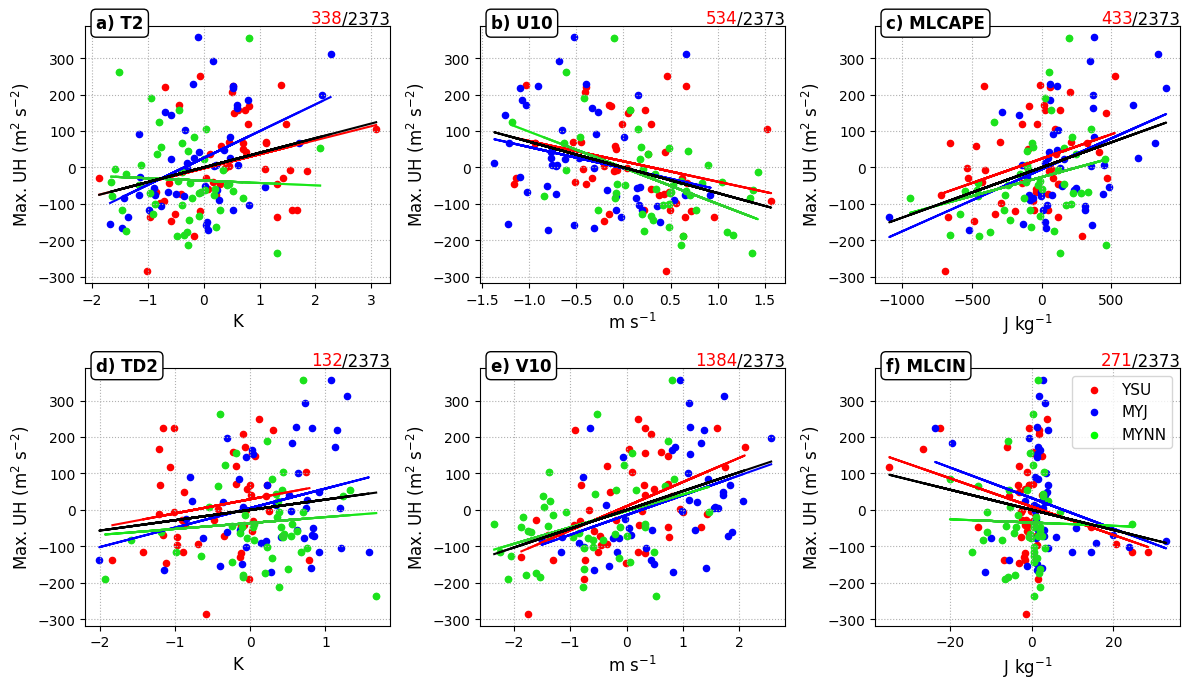

In [8]:
# Set case/plotting specs
save = False
statevars = [t2_interps,u10_interps,mlcape_interps,td2_interps,v10_interps, mlcin_interps]
statestrs = ['T2', 'U10', 'MLCAPE', 'TD2', 'V10', 'MLCIN']
respvar = 'UH_25'
cref = np.mean(cref_interps, axis=(0,1))

    # domain thresholding specs
inflow_region = 'if'
pthres = 0.05
ang_thres = 360
nf_dist = 40 # distance bound of near-inflow domain
ff_dist = 120 # distance bound of far-inflow domain
ang_bound1, ang_bound2 = 40, 230 # angular domain bounds relative to the storm motion
domain_lag = 0 # distance lag of domain origin to storm center in km

dist = (ds1.X_DIST**2 + ds1.Y_DIST**2)**0.5
ang_tot = cr.calc_ang_tot(ds1.X_DIST, ds1.Y_DIST, 0)

################################# Define universal plotting specs ##########################################

xlimleft, xlimright = -40,60
ylimleft, ylimright = -60,50

levels = np.arange(-60,61,10)
ticks = levels[0::4]

axlabels = ['a)','b)','c)','d)','e)','f)','g)','h)']

####### Plot storm-relative sensitivity scatter plot #########

fig3, ax = plt.subplots(2,3, figsize=(12,7))
ax = ax.flatten()

ysustates, myjstates, mynnstates=[],[],[]
for i in range(len(statevars)):
    state_var = statevars[i]
    statestr = statestrs[i]

    pstat = calc_pstat(state_var, respfuncs)
    pstat = np.where(np.isnan(np.mean(state_var, axis=(0,1))), np.nan, pstat)
    
    if inflow_region == 'ff':
        sensvar = np.where( (dist < nf_dist) | (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (pstat > pthres), np.nan, state_var)
    elif inflow_region == 'nf':
        sensvar = np.where(  (dist > nf_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (pstat > pthres), np.nan, state_var)
    elif inflow_region == 'if':
        sensvar = np.where( (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2)  | (pstat > pthres), np.nan, state_var)

    #sensvar = sensvar.reshape(state_var.shape[0]*state_var.shape[1], state_var.shape[2], state_var.shape[3])
    
        # count fraction of grid points within domain with statistical significance
    scatter_count = np.count_nonzero(~np.isnan(sensvar[0,0]))
    domain_count = np.count_nonzero(~np.isnan(np.where( (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2), np.nan, state_var[0,0])))
    
    state_avg = np.nanmean(sensvar, axis=(2,3))
    
    ax[i].scatter(state_avg[:, wofunits.schemeidx['ysu']], respfuncs[:, wofunits.schemeidx['ysu']], color='r', s=20)
    ax[i].scatter(state_avg[:, wofunits.schemeidx['myj']], respfuncs[:, wofunits.schemeidx['myj']], color='b', s=20)
    ax[i].scatter(state_avg[:, wofunits.schemeidx['mynn']], respfuncs[:, wofunits.schemeidx['mynn']], color='lime', alpha=1, s=20)
    ax[i].scatter(state_avg[:, wofunits.schemeidx['mynn']], respfuncs[:, wofunits.schemeidx['mynn']], color='limegreen', alpha=0.5, s=20)
    
    try:
        ysu_state_concat = np.concatenate(state_avg[:, wofunits.schemeidx['ysu']])
        myj_state_concat = np.concatenate(state_avg[:, wofunits.schemeidx['myj']])
        mynn_state_concat = np.concatenate(state_avg[:, wofunits.schemeidx['mynn']])
        ysu_resp_concat = np.concatenate(respfuncs[:, wofunits.schemeidx['ysu']])
        myj_resp_concat = np.concatenate(respfuncs[:, wofunits.schemeidx['myj']])
        mynn_resp_concat = np.concatenate(respfuncs[:, wofunits.schemeidx['mynn']])
        state_concat = np.concatenate(state_avg)
        resp_concat = np.concatenate(respfuncs)
        
        m_ysu,b_ysu=np.polyfit(ysu_state_concat, ysu_resp_concat,1)
        m_myj,b_myj=np.polyfit(myj_state_concat, myj_resp_concat,1)
        m_mynn,b_mynn=np.polyfit(mynn_state_concat, mynn_resp_concat,1)
        m_tot,b_tot=np.polyfit(state_concat, resp_concat,1)
    except:
        pass

    ysustates.append(ysu_state_concat), myjstates.append(myj_state_concat), mynnstates.append(mynn_state_concat)
    
    ax[i].plot(state_avg[:, wofunits.schemeidx['ysu']], m_ysu*state_avg[:, wofunits.schemeidx['ysu']] + b_ysu, color='r')
    ax[i].plot(state_avg[:, wofunits.schemeidx['myj']], m_myj*state_avg[:, wofunits.schemeidx['myj']] + b_myj, color='b')
    ax[i].plot(state_avg[:, wofunits.schemeidx['mynn']], m_mynn*state_avg[:, wofunits.schemeidx['mynn']] + b_mynn, color='lime', alpha=1)
    ax[i].plot(state_avg[:, wofunits.schemeidx['mynn']], m_mynn*state_avg[:, wofunits.schemeidx['mynn']] + b_mynn, color='limegreen', alpha=0.5)
    ax[i].plot(state_avg, m_tot*state_avg + b_tot, c='k')
    
    ax[i].text(0.845, 1.01, f'{scatter_count}', transform=ax[i].transAxes, 
                size=12, color='r', horizontalalignment='right')
    ax[i].text(1, 1.01, f'/{domain_count}', transform=ax[i].transAxes, 
                size=12, color='k', horizontalalignment='right')
        
    if '_TOT' in statestrs[i]:
        #ax[i].set_title(f'{varlist[i][0:5]}0{varlist[i][-1]}', weight='bold', size=12)
        ax[i].text(0.035, 0.99,f'{axlabels[i]} {statestrs[i][0:5]}0{statestrs[i][-1]}', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=12, weight='bold')
    elif '_TRUE' in statestrs[i]:
        ax[i].text(0.035, 0.99,f'{axlabels[i]} {statestrs[i][0:3]}0{statestrs[i][3]}', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=12, weight='bold')
    else:
        #ax[i].set_title(varlist[i], weight='bold', size=12)
        ax[i].text(0.035, 0.99, f'{axlabels[i]} {statestrs[i]}', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=12, weight='bold')
    ax[i].set_xlabel(wofunits.labels[statestrs[i]], size=12)
    ax[i].set_ylabel(f'Max. UH ({wofunits.labels[respvar]})', size=12)
    
    #ax[i].text(0.035, 0.97, axlabels[i], color='k',
    #    bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
    #    size=14, weight='bold')
    
    ax[i].grid(ls=':')
    if i == 5:
        ax[i].legend(['YSU', 'MYJ', 'MYNN'], fontsize=11, loc='upper right')#, loc=(0.04, 0.625))

    plt.tight_layout()
    
    save=False
    if save == True:
        plt.savefig(f'{outpath}/tot_regress_30min_leadtime.png',dpi=300, bbox_inches='tight', facecolor='w')

### Plot composite environments by variable

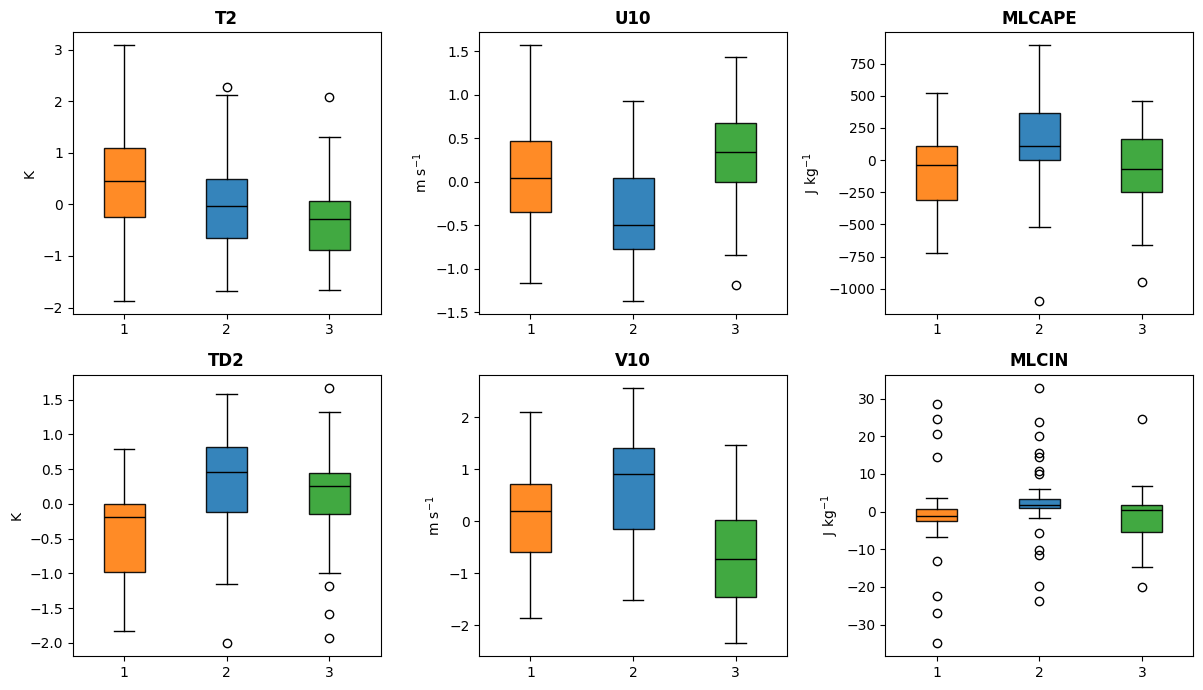

In [9]:
fig, axs = plt.subplots(2,3,figsize=(12,7))
axs=axs.flatten()

for i in range(len(axs)):
    axs[i].boxplot(ysustates[i], positions=[1], widths=0.4, patch_artist=True,
                  medianprops={"color": "k", "linewidth": 1},
                  boxprops={"facecolor": "tab:orange", "edgecolor": "k", "linewidth": 1, "alpha":0.9})
    axs[i].boxplot(myjstates[i], positions=[2], widths=0.4, patch_artist=True,
                  medianprops={"color": "k", "linewidth": 1},
                  boxprops={"facecolor": "tab:blue", "edgecolor": "k", "linewidth": 1, "alpha":0.9})
    axs[i].boxplot(mynnstates[i], positions=[3], widths=0.4, patch_artist=True,
                  medianprops={"color": "k", "linewidth": 1},
                  boxprops={"facecolor": "tab:green", "edgecolor": "k", "linewidth": 1, "alpha":0.9})  

    axs[i].set_ylabel(wofunits.labels[statestrs[i]])
    axs[i].set_title(statestrs[i], weight='bold')

plt.tight_layout()

### Calculate SRH03 full/semipartial sensitivity stats

In [10]:
# Calculate sensitivity statistics
cov_xy = np.sum(srh03_interps * respfuncs[:,:,None,None], axis=(0,1)) / (srh03_interps.shape[0]*state_var.shape[1] - 1)  # (240,240)
var_x  = np.sum(srh03_interps**2, axis=(0,1)) / (srh03_interps.shape[0]*srh03_interps.shape[1] - 1)
std_x = var_x**0.5
sens = cov_xy / var_x
stdsens = sens * std_x
pstat = calc_pstat(srh03_interps, respfuncs)
pstat = np.where(np.isnan(np.mean(srh03_interps, axis=(0,1))), np.nan, pstat)

# Calculate semipartial sensitivity
sens_part, var_part, pstat_part, srh_part, resp_part = semipartial_sensitivity_field(srh03_interps.reshape(144,81,81), respfuncs.reshape(144,), uh_30_lt)
stdsens_part = sens_part * var_part**0.5

/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:49: RuntimeWarning: invalid value encountered in divide
  beta = sumXY / sumXX
/var/folders/rj/ztrh47rj72x4pmrvtbx140jm0000gn/T/ipykernel_7032/4144862496.py:62: RuntimeWarning: invalid value encountered in divide
  SE = np.sqrt(sigma2 / sumXX)


### Plot Fig. 20 full vs. semipartial sensitivity

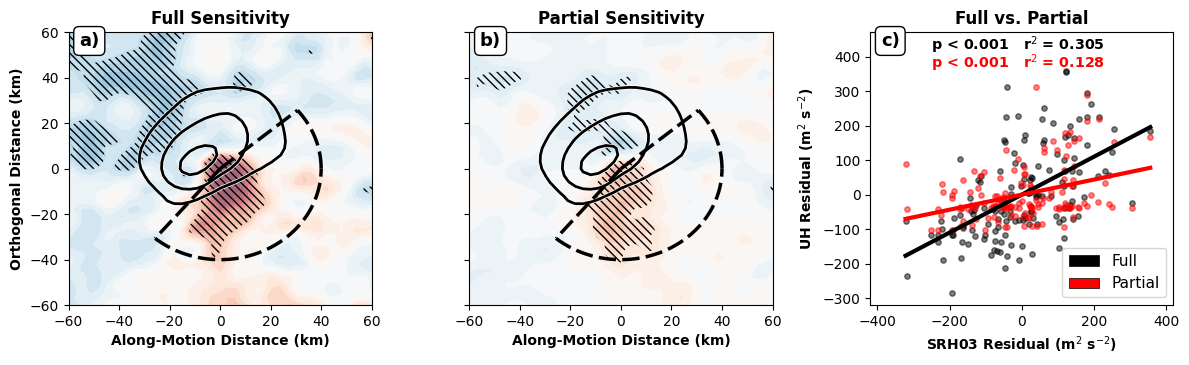

In [11]:
fig, axs = plt.subplots(1,3,figsize=(12,3.75))
axs=axs.flatten()

########## Full sensitivity plot (Fig 20a)###########

cb = axs[0].contourf(ds1.X_DIST, ds1.Y_DIST, stdsens, levels=np.arange(-60,61,5), cmap='RdBu_r', extend='both',
                               antialiased=True, alpha=0.6)
axs[0].contour(ds1.X_DIST, ds1.Y_DIST, cref, linewidths=3, levels=[20,35,50], colors='w', alpha=1)
axs[0].contour(ds1.X_DIST, ds1.Y_DIST, cref, linewidths=2, levels=[20,35,50], colors='k')
axs[0].contourf(ds1.X_DIST, ds1.Y_DIST, pstat, [0, 0.05], colors='none', hatches=['\\\\\\\\'], extend='lower')

cr.plot_domain(storm_ang = 0, 
                    ang_bounds = (ang_bound1, ang_bound2), 
                       if_region='nf', lw=2.5, color='k',
                       subplot=True, ax=axs[0])

axs[0].set_xlim(-60,60)
axs[0].set_ylim(-60,60)

axs[0].set_title('Full Sensitivity', weight='bold', size=12)
axs[0].set_xlabel('Along-Motion Distance (km)', weight='semibold')
axs[0].set_ylabel('Orthogonal Distance (km)', weight='semibold')

axs[0].text(0.035, 0.95, f'a)', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=axs[0].transAxes, 
            size=13, weight='bold')

########## Semipartial sensitivity plot (Fig 20b)###########

axs[1].contourf(ds1.X_DIST, ds1.Y_DIST, stdsens_part, levels=np.arange(-60,61,5), cmap='RdBu_r', extend='both',
                               antialiased=True, alpha=0.6)
axs[1].contour(ds1.X_DIST, ds1.Y_DIST, cref, linewidths=3, levels=[20,35,50], colors='w', alpha=1)
axs[1].contour(ds1.X_DIST, ds1.Y_DIST, cref, linewidths=2, levels=[20,35,50], colors='k')
axs[1].contourf(ds1.X_DIST, ds1.Y_DIST, pstat_part, [0, 0.05], colors='none', hatches=['\\\\\\\\'], extend='lower')

cr.plot_domain(storm_ang = 0, 
                    ang_bounds = (ang_bound1, ang_bound2), 
                       if_region='nf', lw=2.5, color='k',
                       subplot=True, ax=axs[1])

axs[1].set_yticklabels([])
axs[1].set_xlim(-60,60)
axs[1].set_ylim(-60,60)

axs[1].set_title('Partial Sensitivity', weight='bold', size=12)
axs[1].set_xlabel(f'''Along-Motion Distance (km)''', weight='semibold')

axs[1].text(0.035, 0.95, f'b)', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=axs[1].transAxes, 
            size=13, weight='bold')

########## Regression scatters (Fig 20c)###########

    # threshold within near-field inflow domain
srh_part_thres = np.where(  (dist > nf_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (pstat > pthres), np.nan, srh_part)
srh_full_thres = np.where(  (dist > nf_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (pstat > pthres), np.nan, srh03_interps.reshape(144,81,81))

srh_part_mean = np.nanmean(srh_part_thres, axis=(1,2))
srh_full_mean = np.nanmean(srh_full_thres, axis=(1,2))

    # calculate regression stats for near-inflow mean SRH03 vs. response function
m, b, r, p, std_err_ = stats.linregress(srh_full_mean, resp_concat)
m_part, b_part, r_part, p_part, std_err_ = stats.linregress(srh_part_mean, resp_part)
x = np.array([srh_full_mean.min(), srh_full_mean.max()])
x_part = np.array([srh_part_mean.min(), srh_part_mean.max()])

    # plot scatters and regression lines
axs[2].scatter(srh_full_mean, resp_concat, c='k', s=15, alpha=0.5)
axs[2].scatter(srh_part_mean, resp_part, c='r', s=15, alpha=0.5)

axs[2].plot(x, m*x + b, c='k', lw=3)
axs[2].plot(x_part, m_part*x_part + b_part, c='r', lw=3)


if p < 0.001:
    pstr = 'p < 0.001'
else:
    pstr = f'p = ' + '{:.3f}'.format(round(p,3))
if p_part < 0.001:
    ppstr = 'p < 0.001'
else:
    ppstr = f'p = ' + '{:.3f}'.format(round(p_part,3))


axs[2].text(0.2, 0.937, pstr + f'   r$^2$ = ' + '{:.3f}'.format(round(r**2,3)), 
                           color='k', transform=axs[2].transAxes, size=10.25, weight='semibold')
axs[2].text(0.2, 0.87, ppstr + f'   r$^2$ = ' + '{:.3f}'.format(round(r_part**2,3)), 
                           color='r', transform=axs[2].transAxes, size=10.25, weight='semibold')

axs[2].set_title('Full vs. Partial', weight='bold', size=12)
axs[2].set_xlabel(f'''SRH03 Residual ({wofunits.labels['UH_25']})''', weight='semibold')
axs[2].set_ylabel(f'''UH Residual ({wofunits.labels['UH_25']})''', weight='semibold')

rect_full = mpatches.Rectangle((0,0), 0, height=0.4, lw=0.5, edgecolor='k', facecolor='k')
rect_part = mpatches.Rectangle((0,0), 0, height=0.4, lw=0.5, edgecolor='k', facecolor='r')
axs[2].legend(handles=[rect_full, rect_part], 
          labels=['Full', 'Partial'],
          loc='lower right',fancybox=True, fontsize=11)

axs[2].set_xticks(np.arange(-400,401,200))
axs[2].set_yticks(np.arange(-300,401,100))
#axs[2].set_xticklabels(np.arange(-300,301,100))

axs[2].text(0.035, 0.95, f'c)', color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=axs[2].transAxes, 
            size=13, weight='bold')

axs[2].set_xlim(-420,420)
axs[2].set_ylim(-320,470)

fig.tight_layout()

#cbar = fig.colorbar(cb, ax=axs, pad=0.03, shrink=0.85, aspect=15)
#cbar.ax.set_title(f'Std. Sens.\n({wofunits.labels[respvar]})', size=9)
#cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=8)

save=False
plt.savefig(f'{outpath}/partial_sens.png', 
            dpi=300, bbox_inches='tight', facecolor='w')

### Calculate regression stats for all cases and composite (Table 3 stats)

In [12]:
r2s, ps= [],[]
for i in range(len(respfuncs)+1):
    if i == len(respfuncs):
        _, _, r_, p_, _ = stats.linregress(srh_full_mean, respfuncs.flatten())
    else:
        _, _, r_, p_, _ = stats.linregress(srh_full_mean.reshape(4,36)[i], respfuncs[i])
    r2s.append(r_**2), ps.append(p_)

r2s_yz, ps_yz= [],[]
for i in range(len(respfuncs)+1):
    if i == len(respfuncs):
        _, _, r_, p_, _ = stats.linregress(respfuncs.flatten(), uh_30_lt)
    else:
        _, _, r_, p_, _ = stats.linregress(respfuncs[i], uh_30_lt.reshape(4,36)[i])
    r2s_yz.append(r_**2), ps_yz.append(p_)

r2s_part, ps_part= [],[]
for i in range(len(respfuncs)+1):
    if i == len(respfuncs):
        _, _, r_, p_, _ = stats.linregress(srh_part_mean, resp_part)
    else:
        _, _, r_, p_, _ = stats.linregress(srh_part_mean.reshape(4,36)[i], resp_part.reshape(4,36)[i])
    r2s_part.append(r_**2), ps_part.append(p_)

full, yz, semi = np.array(r2s), np.array(r2s_yz), np.array(r2s_part)
fullp, yzp, semip = np.array(ps), np.array(ps_yz), np.array(ps_part)

print('Full R^2:',full)
print('YZ R^2:',yz)
print('Semipartial R^2:', np.round(semi,8))
print('% Autocorr: ', 1 - semi/full)
print('Full p:',fullp)
print('YZ p:',yzp)
print('Semipartial p:', np.round(semip,8))

Full R^2: [0.31976684 0.22011341 0.64021165 0.24154676 0.30487306]
YZ R^2: [0.7887687  0.67249464 0.2402863  0.79470244 0.62497486]
Semipartial R^2: [1.8512429e-01 7.0835180e-02 5.2356365e-01 3.5459000e-04 1.2830393e-01]
% Autocorr:  [0.42106477 0.67818779 0.18220224 0.99853202 0.57915622]
Full p: [3.25817050e-04 3.89564916e-03 4.74350413e-09 2.33434911e-03
 7.29284599e-13]
YZ p: [5.03787622e-13 9.37944655e-10 2.40641014e-03 3.09288840e-13
 4.82608788e-32]
Semipartial p: [8.8116100e-03 1.1665135e-01 6.2000000e-07 9.1319858e-01 1.0430000e-05]
